In [1]:
import sys
import numpy as np
import pandas as pd
import imageio # Import the imageio package
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

# Import BatchNormalization directly from keras.layers
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Concatenate
from keras.layers import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng

### Please give below paths as per the paths in your system

In [2]:
train_folder = "./images_background/"
val_folder = './images_evaluation/'
save_path = './data/'

In [3]:
def loadimgs(path,n = 0):
    '''
    path => Path of train directory or test directory
    '''
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        # every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = cv2.imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

### Loading the train images into tensors

In [4]:
X,y,c=loadimgs(train_folder)

loading alphabet: Alphabet_of_the_Magi
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Arcadian
loading alphabet: Armenian
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Balinese
loading alphabet: Bengali
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Braille
loading alphabet: Burmese_(Myanmar)
loading alphabet: Cyrillic
loading alphabet: Early_Aramaic
loading alphabet: Futurama
loading alphabet: Grantha
loading alphabet: Greek
loading alphabet: Gujarati
loading alphabet: Hebrew
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Japanese_(hiragana)
loading alphabet: Japanese_(katakana)
loading alphabet: Korean
loading alphabet: Latin
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: N_Ko
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Sanskrit
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Tagalog
loading alphabet: Tifinagh


### Saving the train tensors on disk

In [5]:
with open(os.path.join(save_path,"train.pickle"), "wb") as f:
    pickle.dump((X,c),f)

### Loading the validation images into tensors

In [6]:
Xval,yval,cval=loadimgs(val_folder)

loading alphabet: Angelic
loading alphabet: Atemayar_Qelisayer
loading alphabet: Atlantean
loading alphabet: Aurek-Besh
loading alphabet: Avesta
loading alphabet: Ge_ez
loading alphabet: Glagolitic
loading alphabet: Gurmukhi
loading alphabet: Kannada
loading alphabet: Keble
loading alphabet: Malayalam
loading alphabet: Manipuri
loading alphabet: Mongolian
loading alphabet: Old_Church_Slavonic_(Cyrillic)
loading alphabet: Oriya
loading alphabet: Sylheti
loading alphabet: Syriac_(Serto)
loading alphabet: Tengwar
loading alphabet: Tibetan
loading alphabet: ULOG


### Saving the validation tensors on disk

In [7]:
with open(os.path.join(save_path,"val.pickle"), "wb") as f:
    pickle.dump((Xval,cval),f)

In [8]:
# del X, y ,c ,Xval, yval, cval

In [9]:
def initialize_bias(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [10]:
def initialize_weights(shape, dtype=None):
    return np.random.normal(loc=0.0, scale=1e-2, size=shape)

def initialize_bias(shape, dtype=None):
    return np.random.normal(loc=0.5, scale=1e-2, size=shape)


In [11]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
import numpy as np

In [12]:

def get_siamese_model(input_shape=(105, 105, 3)):  # Changed to (105, 105, 3)
    """
    Model architecture for Siamese network handling RGB images.
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10, 10), activation='relu', input_shape=input_shape,
                     kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7, 7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4, 4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4, 4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                    kernel_regularizer=l2(1e-3),
                    kernel_initializer=initialize_weights, bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1, activation='sigmoid', bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)
    
    # return the model
    return siamese_net

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K

In [14]:
initialize_weights = RandomNormal(mean=0.0, stddev=1e-2)
initialize_bias = RandomNormal(mean=0.5, stddev=1e-2)

def get_siamese_model(input_shape=(105, 105, 3)):  # For RGB images (3 channels)
    """
    Model architecture for Siamese network handling RGB images.
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10, 10), activation='relu', input_shape=input_shape,
                     kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7, 7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4, 4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4, 4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                    kernel_regularizer=l2(1e-3),
                    kernel_initializer=initialize_weights, bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1, activation='sigmoid', bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)
    
    # return the model
    return siamese_net

# Instantiate the Siamese model with RGB image shape

# Compile the model


In [15]:
# model = Sequential()

# # Modify input shape to accept RGB images with 3 channels
# model.add(Conv2D(64, (10, 10), activation='relu', input_shape=(105, 105, 3)))
# model.add(MaxPooling2D())
# model.add(Conv2D(128, (7, 7), activation='relu'))
# model.add(MaxPooling2D())
# model.add(Conv2D(128, (4, 4), activation='relu'))
# model.add(MaxPooling2D())
# model.add(Conv2D(256, (4, 4), activation='relu'))
# model.add(Flatten())
# model.add(Dense(4096, activation='sigmoid'))

# # Compile the model
# model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [16]:
model = get_siamese_model((105, 105, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

d:\study\computer-vision\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 4096)      │ 38,960,448 │ input_layer[0][0… │
│ (Sequential)        │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 4096)      │          0 │ sequential[0][0], │
│                     │                   │            │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

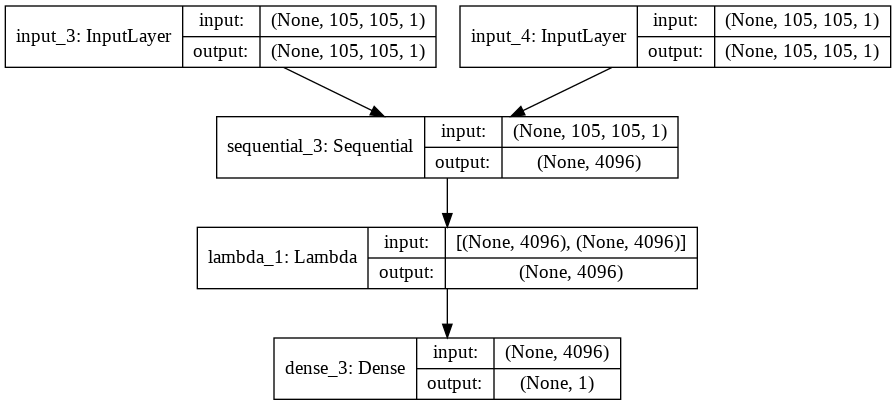

In [17]:
from IPython.display import Image
Image(retina=True, filename='./image.png')

In [18]:
# optimizer = Adam(learning_rate=0.00006)
# model.compile(loss="binary_crossentropy", optimizer=optimizer)

### Loading the train tensors

In [19]:
with open(os.path.join(save_path, "train.pickle"), "rb") as f:
    (Xtrain, train_classes) = pickle.load(f)
    
print("Training alphabets: \n")
print(list(train_classes.keys()))

Training alphabets: 

['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)', 'Balinese', 'Bengali', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Braille', 'Burmese_(Myanmar)', 'Cyrillic', 'Early_Aramaic', 'Futurama', 'Grantha', 'Greek', 'Gujarati', 'Hebrew', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Japanese_(hiragana)', 'Japanese_(katakana)', 'Korean', 'Latin', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'N_Ko', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Sanskrit', 'Syriac_(Estrangelo)', 'Tagalog', 'Tifinagh']


In [20]:
with open(os.path.join(save_path, "val.pickle"), "rb") as f:
    (Xval, val_classes) = pickle.load(f)

print("Validation alphabets:", end="\n\n")
print(list(val_classes.keys()))

Validation alphabets:

['Angelic', 'Atemayar_Qelisayer', 'Atlantean', 'Aurek-Besh', 'Avesta', 'Ge_ez', 'Glagolitic', 'Gurmukhi', 'Kannada', 'Keble', 'Malayalam', 'Manipuri', 'Mongolian', 'Old_Church_Slavonic_(Cyrillic)', 'Oriya', 'Sylheti', 'Syriac_(Serto)', 'Tengwar', 'Tibetan', 'ULOG']


In [50]:
def get_batch(batch_size, s="train"):
    """
    Create batch of n pairs, half same class, half different class
    """
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    
    # Unpacking shape for RGB images
    n_classes, n_examples, w, h, c = X.shape  # The 5th dimension is for channels (RGB)

    # Randomly sample several classes to use in the batch
    categories = rng.choice(n_classes, size=(batch_size,), replace=False)

    # Initialize 2 empty arrays for the input image batch
    # Since the images are RGB, we use 3 channels instead of 1
    pairs = [np.zeros((batch_size, h, w, c)) for i in range(2)]

    # Initialize vector for the targets
    targets = np.zeros((batch_size,))

    # Make one half of it '1's, so 2nd half of batch has the same class
    targets[batch_size // 2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i, :, :, :] = X[category, idx_1]  # No need to reshape, keep the 3 channels
        idx_2 = rng.randint(0, n_examples)

        # Pick images of the same class for the 1st half, different for the 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # Add a random number to the category modulo n_classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1, n_classes)) % n_classes

        pairs[1][i, :, :, :] = X[category_2, idx_2]  # No need to reshape, keep the 3 channels

    return pairs, targets



def generate(batch_size, s="train"):
    """
    a generator for batches, so model.fit_generator can be used.
    """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)


def get_siamese_model(input_shape):
    """
        Model architecture
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

def make_oneshot_task(N, s="val", language=None):
    """Create pairs of test image, support set for testing N-way one-shot learning."""
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes

    # Update unpacking to accommodate the extra dimension
    n_classes, n_examples, w, h, channels = X.shape  # Include the channels dimension

    indices = rng.randint(0, n_examples, size=(N,))
    if language is not None:  # if language is specified, select characters for that language
        low, high = categories[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low, high), size=(N,), replace=False)
    else:  # if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes), size=(N,), replace=False)

    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples, replace=False, size=(2,))
    test_image = np.asarray([X[true_category, ex1, :, :, :]] * N).reshape(N, w, h, channels)  # Adjusted to include channels
    support_set = X[categories, indices, :, :, :]  # Adjusted to include channels
    support_set[0, :, :, :] = X[true_category, ex2]  # Adjusted to include channels
    support_set = support_set.reshape(N, w, h, channels)  # Adjusted to include channels
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image, support_set]
    return pairs, targets

def test_oneshot(model, N, k, s="val", verbose=0):
    """Test average N-way one-shot learning accuracy of a siamese neural net over k tasks."""
    n_correct = 0
    if verbose:
        print(f"Evaluating model on {k} random {N}-way one-shot learning tasks...\n")
    
    for i in range(k):
        # Unpack the pairs and targets returned by make_oneshot_task
        pairs, targets = make_oneshot_task(N, s)  # Correct unpacking
        inputs = pairs  # Assign the pairs to inputs
        probs = model.predict(inputs)
        
        # Determine if the model prediction matches the target
        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1
    
    percent_correct = (100.0 * n_correct / k)
    
    if verbose:
        print(f"Got an average of {percent_correct:.2f}% {N}-way one-shot learning accuracy\n")
    
    return percent_correct



def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

  
def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))
    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [29]:
# Hyper parameters
evaluate_every = 2 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 20 # No. of training iterations
N_way = 20 # how many classes for testing one-shot tasks
n_val = 250 # how many one-shot tasks to validate on
best = -1

In [23]:
model_path = './weights/'

In [24]:
print(X.shape)


(964, 20, 105, 105, 3)


In [25]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()

for i in range(1, n_iter + 1):
    # Fetch a batch of data
    inputs, targets = get_batch(batch_size)
    
    # Train the model on the current batch
    loss = model.train_on_batch(inputs, targets)
    
    if i % evaluate_every == 0:
        elapsed_time = (time.time() - t_start) / 60.0
        print("\n ------------- \n")
        print(f"Time for {i} iterations: {elapsed_time:.2f} mins")
        print(f"Train Loss: {loss}")

        # Evaluate validation accuracy
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        
        # Save model weights
        model.save_weights(os.path.join(model_path, f'{i}.weights.h5'))
        
        # Update and print best validation accuracy if applicable
        if val_acc >= best:
            print(f"Current best: {val_acc}, previous best: {best}")
            best = val_acc


Starting training process!
-------------------------------------

 ------------- 

Time for 2 iterations: 0.11 mins
Train Loss: [array(2.659458, dtype=float32), array(0.5, dtype=float32)]
Evaluating model on 250 random 20-way one-shot learning tasks...

Shape of X: (659, 20, 105, 105, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
Shape of X: (659, 20, 105, 105, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
Shape of X: (659, 20, 105, 105, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
Shape of X: (659, 20, 105, 105, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
Shape of X: (659, 20, 105, 105, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
Shape of X: (659, 20, 105, 105, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
Shape of X: (659, 20, 105, 105, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
Shape of X: (659, 20, 105, 105, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
Shape of X: (659, 20, 105, 105, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
Shape of X: (659, 20, 105, 105, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
Shape 

### Load model weights

In [33]:
model.load_weights(os.path.join(model_path, "20.weights.h5"))

### Testing

### Baseline model based on Nearest Neighbors using Euclidean distance (L2 distance)

In [89]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

In [90]:
def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [34]:
ways = np.arange(1,20,2)
resume =  False
trials = 50

In [35]:
val_accs, train_accs,nn_accs = [], [], []
for N in ways:    
    val_accs.append(test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(test_oneshot(model, N, trials, "train", verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("---------------------------------------------------------------------------------------------------------------")

Evaluating model on 50 random 1-way one-shot learning tasks...

Shape of X: (659, 20, 105, 105, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
Shape of X: (659, 20, 105, 105, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Shape of X: (659, 20, 105, 105, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Shape of X: (659, 20, 105, 105, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Shape of X: (659, 20, 105, 105, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Shape of X: (659, 20, 105, 105, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Shape of X: (659, 20, 105, 105, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Shape of X: (659, 20, 105, 105, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Shape of X: (659, 20, 105, 105, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Shape of X: (659, 20, 105, 105, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Shape of X: (659, 20, 105, 105, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Shape of X: (659, 20, 105, 105, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Shape of X: (659, 20, 105, 105, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━

d:\study\computer-vision\.venv\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20, 105, 105, 3)
Shape of X: (659, 20

### Save the accuracies on disk

In [36]:
with open(os.path.join(save_path,"accuracies.pickle"), "wb") as f:
    pickle.dump((val_accs,train_accs,nn_accs),f)

### Load the accuracies from disk

In [37]:
with open(os.path.join(save_path, "accuracies.pickle"), "rb") as f:
    (val_accs, train_accs, nn_accs) = pickle.load(f)

### Below two functions are used for visualizing test image and support set

In [43]:
import matplotlib.pyplot as plt
import numpy as np

def plot_oneshot_task(pairs):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    
    # Convert RGB to Grayscale for the test image
    test_image_gray = np.mean(pairs[0][0], axis=-1)  # Average over the color channels
    ax1.matshow(test_image_gray.reshape(105, 105), cmap='gray')
    
    # Prepare concatenated support set images
    print(f"Shape of pairs[1]: {pairs[1].shape}")  # Debugging line to check the shape
    img = concat_images(pairs[1])
    ax2.matshow(img, cmap='gray')
    
    # Hide axes
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    plt.xticks([])
    plt.yticks([])

    plt.show()

def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    
    # Verify the shape of X
    print(f"Shape of X in concat_images: {X.shape}")  # Debugging line to check the shape
    
    # Assuming X has shape (n, h, w, c)
    nc, h, w, c = X.shape
    n = np.ceil(np.sqrt(nc)).astype("int8")
    
    # Initialize the image matrix
    img = np.zeros((n * h, n * w))
    
    x = 0
    y = 0
    for example in range(nc):
        img[x * h:(x + 1) * h, y * w:(y + 1) * w] = np.mean(X[example], axis=-1)  # Convert to grayscale
        y += 1
        if y >= n:
            y = 0
            x += 1
            
    return img


In [46]:
best

18.0

Shape of X: (964, 20, 105, 105, 3)
Shape of pairs[1]: (16, 105, 105, 3)
Shape of X in concat_images: (16, 105, 105, 3)


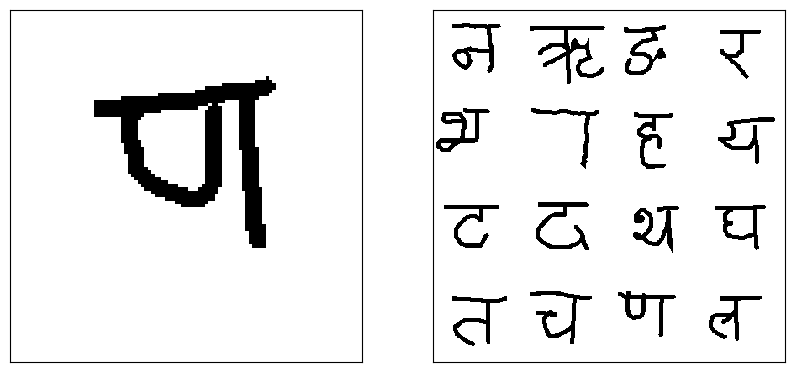

In [44]:
pairs, targets = make_oneshot_task(16,"train","Sanskrit")
plot_oneshot_task(pairs)

### Resuts

Shape of X: (659, 20, 105, 105, 3)


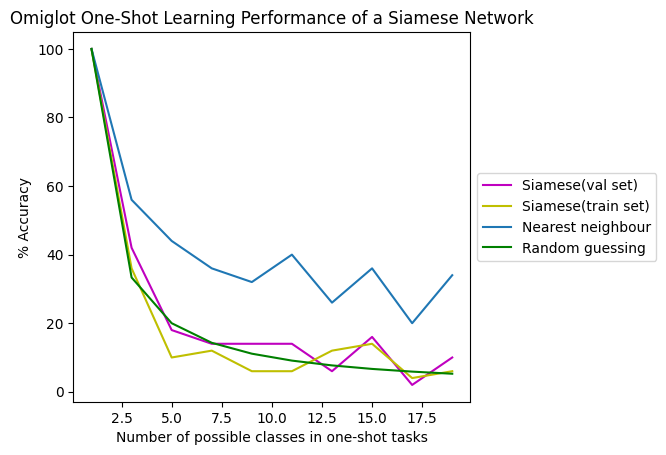

Shape of pairs[1]: (20, 105, 105, 3)
Shape of X in concat_images: (20, 105, 105, 3)


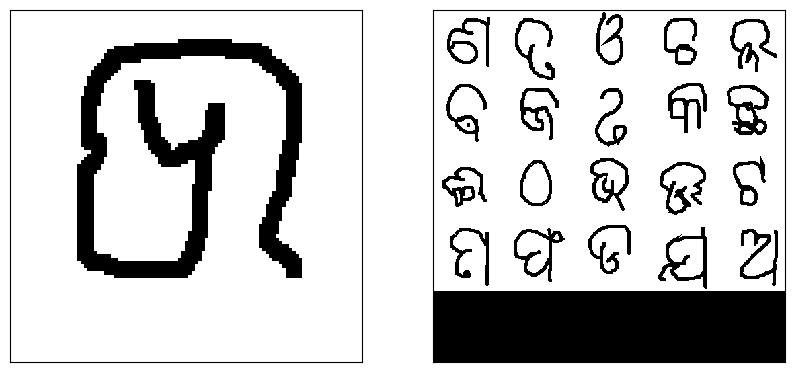

In [45]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = make_oneshot_task(20, "val", 'Oriya')
plt.show()

plot_oneshot_task(inputs)

In [47]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# Load VGG16 model without the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(105, 105, 3))

# Optionally, add custom layers for your specific task
x = base_model.output
x = Flatten()(x)  # Flatten the output
x = Dense(256, activation='relu')(x)
predictions = Dense(N_way, activation='softmax')(x)  # Assuming N_way classes

# Create the final model
vgg16_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [58]:
import numpy as np
from sklearn.utils import shuffle

# Make sure these variables (Xtrain, Xval, train_classes, val_classes) are defined elsewhere in your code
# e.g., from the dataset you're using

rng = np.random.default_rng()  # Random generator for reproducibility

def make_oneshot_task_vgg(N, s="val", language=None):
    """Create pairs of test image, support set for testing N-way one-shot learning."""
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes

    # Update unpacking to accommodate the extra dimension
    n_classes, n_examples, w, h, channels = X.shape  # Include the channels dimension

    indices = rng.integers(0, n_examples, size=(N,))
    if language is not None:
        low, high = categories[language]
        if N > high - low:
            raise ValueError(f"This language ({language}) has fewer than {N} letters.")
        categories = rng.choice(range(low, high), size=(N,), replace=False)
    else:
        categories = rng.choice(range(n_classes), size=(N,), replace=False)

    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples, replace=False, size=(2,))
    
    # Create the test image (broadcasted N times) and the support set
    test_image = np.asarray([X[true_category, ex1]] * N).reshape(N, w, h, channels)
    support_set = X[categories, indices]
    support_set[0] = X[true_category, ex2]  # Ensure one support set is the same category as the test image

    support_set = support_set.reshape(N, w, h, channels)
    targets = np.zeros((N,))
    targets[0] = 1  # The first target corresponds to the correct match
    
    # Shuffle to avoid always having the correct pair in the first position
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    
    # Pair the test images with the support set
    pairs = [test_image, support_set]  # This will be reshaped/used properly in the test function
    return pairs, targets

def preprocess_data(pairs):
    """Preprocess data for VGG16."""
    pairs[0] = tf.keras.applications.vgg16.preprocess_input(pairs[0])
    pairs[1] = tf.keras.applications.vgg16.preprocess_input(pairs[1])
    return pairs

def test_oneshot_vgg(model, N, k, s="val", verbose=0):
    """Test average N-way one-shot learning accuracy of a model over k tasks."""
    n_correct = 0
    if verbose:
        print(f"Evaluating model on {k} random {N}-way one-shot learning tasks...\n")
    
    for i in range(k):
        pairs, targets = make_oneshot_task_vgg(N, s)
        
        # Preprocess the pairs
        pairs = preprocess_data(pairs)
        
        # Flatten the test image and support set to feed into the model (concatenate inputs)
        inputs = np.concatenate([pairs[0], pairs[1]], axis=0)
        
        # Predict the probability of each class
        probs = model.predict(inputs)
        
        # Determine if the model prediction matches the target
        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1
    
    percent_correct = (100.0 * n_correct / k)
    
    if verbose:
        print(f"Got an average of {percent_correct:.2f}% {N}-way one-shot learning accuracy\n")
    
    return percent_correct


In [57]:
def plot_oneshot_task_vgg(pairs):
    """Visualizes the one-shot task."""
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

    # Plot the test image (first pair)
    ax1.matshow(pairs[0][0].reshape(105, 105, 3))
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)

    # Prepare concatenated support set images
    img = concat_images_vgg(np.array(pairs[1]))  # Ensure it's a NumPy array
    ax2.matshow(img, cmap='gray')

    plt.xticks([])
    plt.yticks([])
    plt.show()

# Concatenate images for plotting purposes
def concat_images_vgg(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h, w, _ = X.shape
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n * h, n * w, 3))  # Ensure proper height and width arrangement

    x = 0
    y = 0
    for example in range(nc):
        img[x * h:(x + 1) * h, y * w:(y + 1) * w, :] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

# Train and evaluate the model
def train_and_evaluate_model_vgg(model, n_iter, evaluate_every, N_way, n_val):
    for i in range(n_iter):
        print(f'Iteration {i + 1}/{n_iter}')
        
        # Dummy training loss (replace with actual training logic)
        loss = np.random.rand(1)
        print(f"Train Loss: {loss}")

        # Every `evaluate_every` iterations, evaluate one-shot learning accuracy
        if i % evaluate_every == 0:
            val_acc = test_oneshot_vgg(model, N_way, n_val, verbose=True)
            print(f'Validation Accuracy at iteration {i}: {val_acc}')
            
            # Save the best model
            if val_acc > best:
                model.save_weights(f'best_weights_iter_{i}.h5')

# Run the evaluation


In [59]:
vgg16_acc = test_oneshot_vgg(vgg16_model, N_way, n_val, verbose=True)
print(f'VGG16 One-shot Accuracy: {vgg16_acc:.4f}')

Evaluating model on 250 random 20-way one-shot learning tasks...

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 576ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/ste

In [63]:
# Initialize lists to store VGG16 accuracies
vgg_val_accs = []
vgg_train_accs = []

# Number of classes in each N-way one-shot task (e.g., 5-way, 10-way, 20-way, etc.)
ways = [5, 10, 20, 50, 100]  # Adjust this list as needed for your experiments

# Number of tasks to evaluate for validation and training sets
n_val = 25  # Number of validation tasks
n_train = 25  # Number of training tasks

# Loop over different N-way tasks to evaluate the VGG16 model
for N in ways:
    # Evaluate the VGG16 model on validation set for N-way one-shot tasks
    val_acc = test_oneshot_vgg(vgg16_model, N, n_val, s="val", verbose=True)
    vgg_val_accs.append(val_acc)
    
    # Evaluate the VGG16 model on training set for N-way one-shot tasks
    train_acc = test_oneshot_vgg(vgg16_model, N, n_train, s="train", verbose=True)
    vgg_train_accs.append(train_acc)

# Now you have the validation and training accuracies for VGG16 model stored in vgg_val_accs and vgg_train_accs


Evaluating model on 25 random 5-way one-shot learning tasks...

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


In [65]:
# Ensure all accuracy lists have the same length as 'ways'
print(f"Length of ways: {len(ways)}")
print(f"Length of vgg_val_accs: {len(vgg_val_accs)}")
print(f"Length of vgg_train_accs: {len(vgg_train_accs)}")
print(f"Length of val_accs: {len(val_accs)}")
print(f"Length of train_accs: {len(train_accs)}")
print(f"Length of nn_accs: {len(nn_accs)}")


Length of ways: 5
Length of vgg_val_accs: 5
Length of vgg_train_accs: 5
Length of val_accs: 10
Length of train_accs: 10
Length of nn_accs: 10


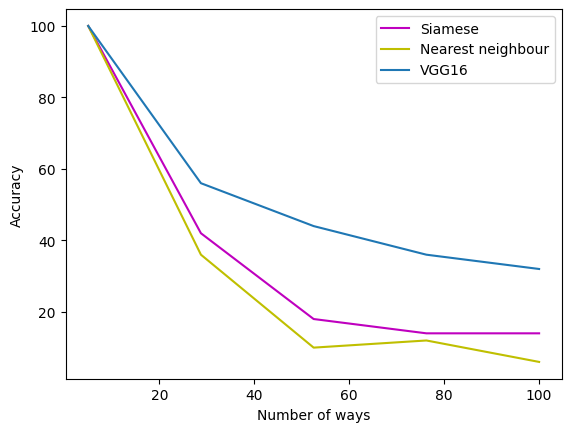

In [71]:
import numpy as np

# Create a new 'ways' array with 10 points (matching the length of the accuracy arrays)
new_ways = np.linspace(ways[0], ways[-1], num=len(val_accs))

# Now plot with the new 'ways' array
fig, ax = plt.subplots(1)


ax.plot(new_ways, val_accs, "m", label="Siamese")
ax.plot(new_ways, nn_accs, "y", label="Nearest neighbour")
ax.plot(new_ways, val_accs, label="VGG16")
# Plot the accuracies

# Labels and legend
ax.set_xlabel("Number of ways")
ax.set_ylabel("Accuracy")
ax.legend()

plt.show()
